In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
import monte_carlo as mc
import black_scholes as bs
import binomial_tree as bt
import payoff as po
import timeit

# Option Pricing with Binomial Trees, Monte Carlo, and Black–Scholes

For constant volatility and interest rate, option prices can be estimated using:

- **Binomial trees** (European and American options),
- **Monte Carlo simulation** under the risk-neutral measure,
- **Closed-form Black–Scholes formula** (for European options).

We will compare these approaches on a non-dividend-paying underlying with:

- Strike $K = 100$,
- Expiry $T = 1$ year,
- Interest rate $r = 5\%$ p.a.,
- Volatility $\sigma$ = 20\%$/\sqrt{\text{year}}$.

In [2]:
Srange = np.linspace(50,150,30)
K = 100
T = 1
r = 0.05
sigma = 0.2
payoff = lambda S:po.payoff_call(S,K)

In [ ]:
price_mc_1e1,errstd_mc_1e1 = mc.MC_price_fast(Srange,r,sigma,T,T,payoff,10)
price_mc_1e2,errstd_mc_1e2 = mc.MC_price_fast(Srange,r,sigma,T,T,payoff,100)
price_mc_1e3,errstd_mc_1e3 = mc.MC_price_fast(Srange,r,sigma,T,T,payoff,1000)


In [ ]:
price_bt_1step = []
price_bt_10step = []
price_bt_100step = []
price_bs = []
for S0 in Srange:
    price_bt_1step.append(bt.eval_option_tree(S0,K,r,sigma,1,1,'call','european'))
    price_bt_10step.append(bt.eval_option_tree(S0,K,r,sigma,1,10,'call','european'))
    price_bt_100step.append(bt.eval_option_tree(S0,K,r,sigma,1,100,'call','european'))
    price_bs.append(bs.bs_formula_price(S0, K, r, 0,sigma, T, 'call'))
price_bt_1step = np.array(price_bt_1step)
price_bt_10step = np.array(price_bt_10step)
price_bt_100step = np.array(price_bt_100step)
price_bs = np.array(price_bs)

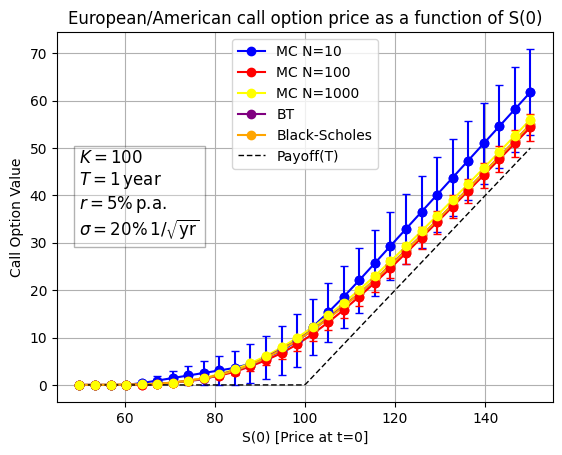

In [27]:
plt.plot(Srange, price_mc_1e1, marker='o',color='blue',label='MC N=10')
plt.errorbar(Srange, price_mc_1e1, yerr=errstd_mc_1e1, fmt='o', color='blue', capsize=3)
plt.plot(Srange, price_mc_1e2, marker='o',color='red',label='MC N=100')
plt.errorbar(Srange, price_mc_1e2, yerr=errstd_mc_1e2, fmt='o', color='red', capsize=3)
plt.plot(Srange, price_mc_1e3, marker='o',color='yellow',label='MC N=1000')
plt.errorbar(Srange, price_mc_1e3, yerr=errstd_mc_1e3, fmt='o', color='yellow', capsize=3)
# plt.plot(Srange, price_bt_1step, marker='o',color='green',label='BT 1 step')
plt.plot(Srange, price_bt_10step, marker='o',color='purple',label='BT')
plt.plot(Srange, price_bs, marker='o',color='orange',label='Black-Scholes')
Srange_fine = np.linspace(50,150,300)
plt.plot(Srange_fine, np.maximum(Srange_fine-K,0),color='black',label='Payoff(T)',linewidth=1,dashes=(4,2))
plt.xlabel("S(0) [Price at t=0]")
plt.ylabel("Call Option Value")
plt.title("European/American call option price as a function of S(0)")
plt.legend()
plt.grid(True)
plt.text(50, 40, r'$K=100$'+"\n"+r'$T=1\,\text{year}$'+"\n"+r'$r=5\%\,\text{p.a.}$'+"\n"+r'$\sigma=20\%\,1/\sqrt{\text{yr}}$', fontsize=12, color="black", ha="left", va="center",bbox=dict(boxstyle="square", facecolor="white", edgecolor="black",alpha=0.3))
plt.savefig("../plots/call_vs_S0.png", dpi=300, bbox_inches="tight")

## Convergence to Black–Scholes

To quantify convergence, we plot


$\Delta P_i = \left| 1 - \frac{P_i}{P_{\text{BS}}} \right|$ for $i \in \{\text{BT}, \text{MC}\}$,  

where $P_{\text{BS}}$ is the Black–Scholes benchmark price.

- Monte Carlo estimates use $N = 10, 10^3$ simulated paths.  
- Binomial tree estimates use $N = 10, 100$ steps.

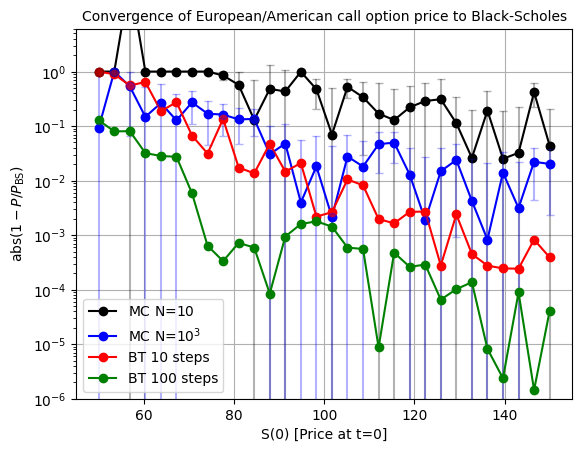

In [33]:
plt.plot(Srange,np.abs(1-price_mc_1e1[:,0]/price_bs), marker='o',color='black',label=r'MC N=$10$')
plt.errorbar(Srange, np.abs(1-price_mc_1e1[:,0]/price_bs), yerr=abs(price_mc_1e1[:,1]/price_bs), fmt='o', color='black', capsize=3,alpha=0.3)
plt.plot(Srange,np.abs(1-price_mc_1e3[:,0]/price_bs), marker='o',color='blue',label=r'MC N=$10^3$')
plt.errorbar(Srange, np.abs(1-price_mc_1e3[:,0]/price_bs), yerr=abs(price_mc_1e3[:,1]/price_bs), fmt='o', color='blue', capsize=3,alpha=0.3)
plt.plot(Srange,np.abs(1-price_bt_10step/price_bs), marker='o',color='red',label=r'BT 10 steps')
plt.plot(Srange,np.abs(1-price_bt_100step/price_bs), marker='o',color='green',label=r'BT 100 steps')
plt.yscale('log')   # log scale on y-axis
plt.ylim(0.000001, 6) 
plt.xlabel("S(0) [Price at t=0]")
plt.ylabel(r'$\text{abs}\left( 1-P/P_{\text{BS}}\right)$')
plt.title("Convergence of European/American call option price to Black-Scholes",fontsize = '10')
plt.legend()
plt.grid(True)
plt.savefig("../plots/call_vs_S0_conv.png", dpi=300, bbox_inches="tight")

The results show good agreement among all methods and better agreement with increased value of $N$.
In particular, the Monte Carlo estimator converges toward the Black–Scholes result as the number of simulations increases, with statistical error decreasing as $O(1/\sqrt{N})$.

## Call Price vs. Strike

We now fix $S_0 = 100$ and vary the strike price $K$.  
All three methods (MC, BT, BS) are compared.

Results confirm the expected behavior:

- Decreasing strike → option is deeper in the money → higher value.  
- Increasing strike → option is further out of the money → lower value.

In [34]:
Krange = np.linspace(50,150,30)
S0 = 100
T = 1
r = 0.05
sigma = 0.2
payoff = lambda S:po.payoff_call(S,K)
price_mc_1e1 = []
price_mc_1e2 = []
price_mc_1e3 = []
price_bt_1step = []
price_bt_10step = []
price_bs = []
for K in Krange:
    price_mc_1e1.append(mc.MC_price(S0,r,sigma,T,T,payoff,10**1))
    price_mc_1e2.append(mc.MC_price(S0,r,sigma,T,T,payoff,10**2))
    price_mc_1e3.append(mc.MC_price(S0,r,sigma,T,T,payoff,10**3))
    price_bt_1step.append(bt.eval_option_tree(S0,K,r,sigma,1,1,'call','european'))
    price_bt_10step.append(bt.eval_option_tree(S0,K,r,sigma,1,10,'call','european'))
    price_bs.append(bs.bs_formula_price(S0, K, r, 0,sigma, T, 'call'))
price_mc_1e1 = np.array(price_mc_1e1)
price_mc_1e2 = np.array(price_mc_1e2)
price_mc_1e3 = np.array(price_mc_1e3)
price_bt_1step = np.array(price_bt_1step)
price_bt_10step = np.array(price_bt_10step)
price_bs = np.array(price_bs)

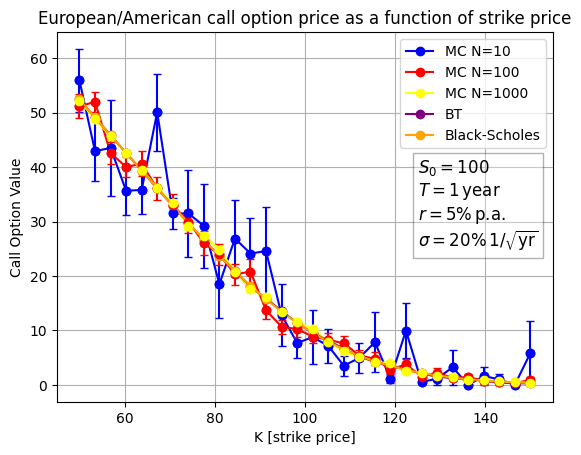

In [41]:
plt.plot(Krange, price_mc_1e1[:,0], marker='o',color='blue',label='MC N=10')
plt.errorbar(Krange, price_mc_1e1[:,0], yerr=price_mc_1e1[:,1], fmt='o', color='blue', capsize=3)
plt.plot(Krange, price_mc_1e2[:,0], marker='o',color='red',label='MC N=100')
plt.errorbar(Krange, price_mc_1e2[:,0], yerr=price_mc_1e2[:,1], fmt='o', color='red', capsize=3)
plt.plot(Krange, price_mc_1e3[:,0], marker='o',color='yellow',label='MC N=1000')
plt.errorbar(Krange, price_mc_1e3[:,0], yerr=price_mc_1e3[:,1], fmt='o', color='yellow', capsize=3)
# plt.plot(Krange, price_bt_1step, marker='o',color='green',label='BT 1 step')
plt.plot(Krange, price_bt_10step, marker='o',color='purple',label='BT')
plt.plot(Krange, price_bs, marker='o',color='orange',label='Black-Scholes')
plt.xlabel("K [strike price]")
plt.ylabel("Call Option Value")
plt.title("European/American call option price as a function of strike price")
plt.legend()
plt.grid(True)
plt.text(125, 33, r'$S_0=100$'+"\n"+r'$T=1\,\text{year}$'+"\n"+r'$r=5\%\,\text{p.a.}$'+"\n"+r'$\sigma=20\%\,1/\sqrt{\text{yr}}$', fontsize=12, color="black", ha="left", va="center",bbox=dict(boxstyle="square", facecolor="white", edgecolor="black",alpha=0.3))
plt.savefig("../plots/call_vs_K.png", dpi=300, bbox_inches="tight")

## Put Price: American vs. European

Puts highlight the impact of **early exercise**.  
We compute put prices using binomial trees for both American and European contracts with:

- Strikes $K = 100$,  
- Expiries $T = 1$ and $T = 5$ years,  
- Interest rate $r = 5\%$,  
- Volatility $\sigma = 20\%$.

This reveals the **early exercise premium**: American puts can be more valuable than European puts, especially at longer maturities.

In [42]:
Srange = np.linspace(50,150,30)
K = 100
T1 = 1
T2 = 5
r = 0.05
sigma = 0.2

price_US_1year = []
price_US_5year = []
price_EU_1year = []
price_EU_5year = []

for S0 in Srange:

    price_US_1year.append(bt.eval_option_tree(S0,K,r,sigma,T1,100,'put','american'))
    price_US_5year.append(bt.eval_option_tree(S0,K,r,sigma,T2,100,'put','american'))
    price_EU_1year.append(bt.eval_option_tree(S0,K,r,sigma,T1,100,'put','european'))
    price_EU_5year.append(bt.eval_option_tree(S0,K,r,sigma,T2,100,'put','european'))
    

price_US_1year = np.array(price_US_1year)
price_US_5year = np.array(price_US_5year)
price_EU_1year = np.array(price_EU_1year)
price_EU_5year = np.array(price_EU_5year)

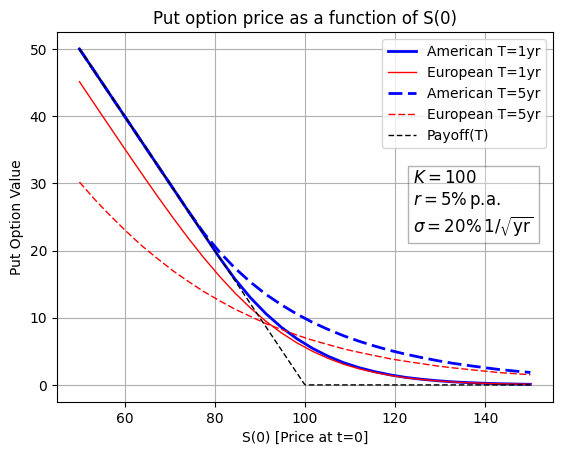

In [49]:
plt.plot(Srange, price_US_1year, marker='',markersize=4,label="American T=1yr", linewidth=2,color='blue')
plt.plot(Srange, price_EU_1year, marker='',markersize=4,label="European T=1yr", linewidth=1,color='red')
plt.plot(Srange, price_US_5year, marker='',markersize=4,label="American T=5yr", linewidth=2,dashes=(5,2),color='blue')
plt.plot(Srange, price_EU_5year, marker='',markersize=4,label="European T=5yr", linewidth=1,dashes=(5,2),color='red')
Srange_fine = np.linspace(50,150,300)
plt.plot(Srange_fine, np.maximum(K-Srange_fine,0),color='black',label='Payoff(T)',linewidth=1,dashes=(4,2))
plt.xlabel("S(0) [Price at t=0]")
plt.ylabel("Put Option Value")
plt.title("Put option price as a function of S(0)")
plt.legend()
plt.grid(True)
plt.text(124, 27, r'$K=100$'+"\n"+r'$r=5\%\,\text{p.a.}$'+"\n"+r'$\sigma=20\%\,1/\sqrt{\text{yr}}$', fontsize=12, color="black", ha="left", va="center",bbox=dict(boxstyle="square", facecolor="white", edgecolor="black",alpha=0.3))
plt.savefig("../plots/put_vs_S0.png", dpi=300, bbox_inches="tight")

Key insights:

- **European puts (deep ITM):** Price decreases with longer expiry, since the position has more time to drift OTM. Shorter maturities carry higher probability of staying ITM.  
- **European puts (OTM):** Longer maturities increase value, as the underlying has more time to diffuse into ITM.  
- **American puts:** Deep ITM positions asymptote to the intrinsic payoff due to the incentive for early exercise. OTM positions gain time value, similar to European options but with higher overall value.

## Put Price vs. Expiry

We now slice differently, plotting **European put price vs. expiry** for:

- $S_0 = \{60, 120\}$,  
- $K = 100$,  
- Volatilities $\sigma = \{20\%, 40\%\}$.

Findings:

- For ITM options, lower volatility implies higher certainty; the exponential discount dominates, suppressing value with longer expiry.  
- For OTM options, higher volatility increases the chance of reaching ITM, so value grows with maturity.  
- Larger volatility reduces sensitivity to expiry for ITM options but increases sensitivity for OTM options.

In [51]:
Trange = np.linspace(1/12,5,30)
K = 100
S0_low = 60
S0_high = 120
r = 0.05
sigma = 0.2

price_EU_low_02 = []
price_EU_high_02 = []
price_EU_low_04 = []
price_EU_high_04 = []

for T in Trange:

    price_EU_low_02.append(bt.eval_option_tree(S0_low,K,r,sigma,T,100,'put','european'))
    price_EU_high_02.append(bt.eval_option_tree(S0_high,K,r,sigma,T,100,'put','european'))
    price_EU_low_04.append(bt.eval_option_tree(S0_low,K,r,2*sigma,T,100,'put','european'))
    price_EU_high_04.append(bt.eval_option_tree(S0_high,K,r,2*sigma,T,100,'put','european'))
    

price_EU_low_02 = np.array(price_EU_low_02)
price_EU_high_02 = np.array(price_EU_high_02)
price_EU_low_04 = np.array(price_EU_low_04)
price_EU_high_04 = np.array(price_EU_high_04)

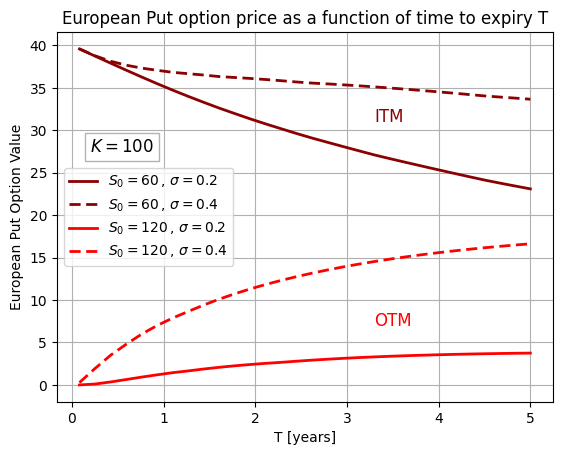

In [60]:
plt.plot(Trange, price_EU_low_02, label=r'$S_0=60\,,\, \sigma=0.2$', linewidth=2,color='darkred')
plt.plot(Trange, price_EU_low_04, label=r'$S_0=60\,,\, \sigma=0.4$', linewidth=2,dashes=(4,2),color='darkred')
plt.plot(Trange, price_EU_high_02, label=r'$S_0=120\,,\, \sigma=0.2$', linewidth=2,color='red')
plt.plot(Trange, price_EU_high_04, label=r'$S_0=120\,,\, \sigma=0.4$', linewidth=2,dashes=(4,2),color='red')
plt.xlabel("T [years]")
plt.ylabel("European Put Option Value")
plt.title("European Put option price as a function of time to expiry T")
plt.legend()
plt.text(3.3, 31, "ITM", fontsize=12, color="darkred")
plt.text(3.3, 7, "OTM", fontsize=12, color="red")
plt.grid(True)
plt.grid(True)
plt.text(0.2, 28, r'$K=100$', fontsize=12, color="black", ha="left", va="center",bbox=dict(boxstyle="square", facecolor="white", edgecolor="black",alpha=0.3))
plt.savefig("../plots/put_vs_T.png", dpi=300, bbox_inches="tight")


## Put Price vs. Volatility

Finally, we fix expiry ($T = 1, 5$ years) and plot **European put prices vs. volatility** for:

- $S_0 = \{60, 120\}$,  
- $K = 100$,  
- $r = 5\%$.

Interpretation:

- **ITM puts:** At low volatility, the price approaches
 
  $\lim_{\sigma \to 0} P = (K - S_0) e^{-rT}\,.$

  Longer maturities suppress value more strongly.  
  At higher volatility, diffusion increases the chance of ending deeper ITM, so expiry sensitivity diminishes.  

- **OTM puts:** At low volatility, option remains worthless.  
  At higher volatility, longer expiry increases the chance of ending ITM, and the gap between short and long maturities widens.

In [61]:
sigmarange = np.linspace(0.01,0.4,50)
K = 100
S0_low = 60
S0_high = 120
r = 0.05
T_low = 1
T_high = 5

price_EU_low_1 = []
price_EU_high_1 = []
price_EU_low_5 = []
price_EU_high_5 = []

for sigma in sigmarange:

    price_EU_low_1.append(bt.eval_option_tree(S0_low,K,r,sigma,T_low,100,'put','european'))
    price_EU_high_1.append(bt.eval_option_tree(S0_high,K,r,sigma,T_low,100,'put','european'))
    price_EU_low_5.append(bt.eval_option_tree(S0_low,K,r,sigma,T_high,100,'put','european'))
    price_EU_high_5.append(bt.eval_option_tree(S0_high,K,r,sigma,T_high,100,'put','european'))
    

price_EU_low_1 = np.array(price_EU_low_1)
price_EU_high_1 = np.array(price_EU_high_1)
price_EU_low_5 = np.array(price_EU_low_5)
price_EU_high_5 = np.array(price_EU_high_5)

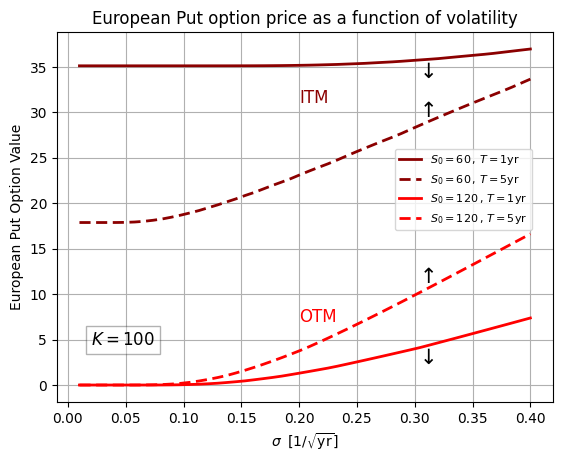

In [72]:
plt.plot(sigmarange, price_EU_low_1, label=r'$S_0=60\,,\, T=1 \text{yr}$', linewidth=2,color='darkred')
plt.plot(sigmarange, price_EU_low_5, label=r'$S_0=60\,,\, T=5\text{yr}$', linewidth=2,dashes=(4,2),color='darkred')
plt.plot(sigmarange, price_EU_high_1, label=r'$S_0=120\,,\, T=1\text{yr}$', linewidth=2,color='red')
plt.plot(sigmarange, price_EU_high_5, label=r'$S_0=120\,,\, T=5\text{yr}$', linewidth=2,dashes=(4,2),color='red')
plt.xlabel(r'$\sigma\;\; [1/\sqrt{\text{yr}}]$')
plt.ylabel("European Put Option Value")
plt.title("European Put option price as a function of volatility")
plt.legend(loc="upper left", bbox_to_anchor=(0.67, 0.7),fontsize=8)
plt.text(0.2, 31, "ITM", fontsize=12, color="darkred")
plt.text(0.2, 7, "OTM", fontsize=12, color="red")
plt.text(0.3, 29.5, r'$\uparrow$', fontsize=15, color="black")
plt.text(0.3, 33.8, r'$\downarrow$', fontsize=15, color="black")
plt.text(0.3, 11.2, r'$\uparrow$', fontsize=15, color="black")
plt.text(0.3, 2.3, r'$\downarrow$', fontsize=15, color="black")
plt.grid(True)
plt.text(0.02, 5, r'$K=100$', fontsize=12, color="black", ha="left", va="center",bbox=dict(boxstyle="square", facecolor="white", edgecolor="black",alpha=0.3))

plt.savefig("../plots/put_vs_Sigma.png", dpi=300, bbox_inches="tight")


# Summary

**Findings:**
- Binomial trees converge to Black–Scholes as steps → ∞.  
- Monte Carlo estimates converge at rate $O(1/\sqrt{N})$.  
- American puts show an early exercise premium over European puts, larger at long maturities.  
- Option values demonstrate expected sensitivities to strike, expiry, and volatility.  

**Skills demonstrated:**
- Stochastic simulation (Monte Carlo, GBM).  
- Numerical methods (binomial tree, convergence analysis).  
- Analytical finance (Black–Scholes model, payoff structures).  
- Data visualization and interpretation in Python/Jupyter.  